# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl

rm: cannot remove 'dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl': No such file or directory


In [3]:

class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))

paths = {}
keys = train_paths.keys()
for key in list(keys)[0:7]:
    paths.update({key: train_paths[key]})
train_paths = paths

print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)

    

{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}, '20140107': {'y': 'dataset/Kyoto2016/2014/01/20140107_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140107_x.csv'}, '20140109': {'x': 'dataset/Kyoto2016/2014/01/20140109_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140109_y.csv'}, '20140104': {'y': 'dataset/Kyoto2016/2014/01/20140104_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140104_x.csv'}, '20140119': {'x': 'dataset/Kyoto2016/2014/01/20140119_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140119_y.csv'}, '20140120': {'x': 'dataset/Kyoto2016/2014/01/20140120_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140120_y.csv'}, '20140123': {'x': 'dataset/Kyoto2016/2014/01/20140123_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140123_y.csv'}, '20140118': {'x': 'dataset/Kyoto2016/2014/01/20140118_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140118_y.csv'}}
----------------------------------------------------------------------------------------
{'20151224': {

In [4]:
import tensorflow as tf
from sklearn import model_selection as ms
from sklearn import metrics as me

In [5]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 42
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [6]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                            train_batch()

                            count = 10
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                                print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()
                                count -=1

                            #summary_writer_train.add_summary(summary_str, epoch)
                            #if(train_loss > 1e9):

                            #print("{:.6f}".format(train_loss), end = ", " )

                        #print("")
                        valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                             net.y_: y_valid, 
                                                                             net.keep_prob:1, net.lr:lr})
                    end_time = time.perf_counter()
                    for key, x_test, y_test in preprocess.get_data(test_paths):

                        accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                       net.pred, 
                                                                       net.actual, net.y], 
                                                                      feed_dict={net.x: x_test, 
                                                                                 net.y_: y_test, 
                                                                                 net.keep_prob:1, net.lr:lr})
                        f1_score = me.f1_score(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        print("Key {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, f1_score: {}".format(key, train_loss, valid_accuracy, accuracy, f1_score))
                       

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy

                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)


                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):
                                                  (curr_pred, 
                                                   Train.result(key, f, h,valid_accuracy, accuracy, f1_score, end_time - start_time))})



In [7]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        print("********************************** Training ******************************")
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [1, 4, 8, 16, 42]
        hidden_layers_arr = [1, 3]

        epochs = [1]
        lrs = [1e-5]
        print("***************************** Entering Loop **********************")
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl'):
            past_scores = df_results#temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

        past_scores.append(df_results, ignore_index=True).to_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

In [8]:
#%%timeit
Hyperparameters.start_training()

********************************** Training ******************************
***************************** Entering Loop **********************
Current Layer Attributes - hidden layers:1 features count:1
Key 20151224 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.982887, f1_score: 0.9913694351355774
Key 20151204 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.986750, f1_score: 0.9933310021881523
Key 20151216 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.978838, f1_score: 0.9893056189838565
Key 20151222 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.986742, f1_score: 0.9933266422386666
Key 20151214 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.984972, f1_score: 0.9924291376120528
Key 20151202 | Training Loss: 0.009191 | Train Accuracy: 0.994156 | Test Accuracy: 0.953520, f1_score: 0.976207067357339
Key 20151227 | Training Loss: 0.009191 | Train Accuracy: 0.994156 |

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Key 20151224 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.017113, f1_score: 0.0
Key 20151204 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.013250, f1_score: 0.0
Key 20151216 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.021162, f1_score: 0.0
Key 20151222 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.013258, f1_score: 0.0
Key 20151214 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.015028, f1_score: 0.0
Key 20151202 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.046480, f1_score: 0.0
Key 20151227 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.011803, f1_score: 0.0
Key 20151203 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.093747, f1_score: 0.0
Key 20151223 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.034788, f1_score: 0.0
Key 20151205 | Training Loss: nan | Train Accuracy: 0.005937 | Test Accuracy: 0.01

Key 20151215 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.019191, f1_score: 0.0
Key 20151213 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.009403, f1_score: 0.0
Key 20151209 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.017705, f1_score: 0.0
Key 20151228 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.011314, f1_score: 0.0
Key 20151226 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.097530, f1_score: 0.0
Key 20151218 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.021169, f1_score: 0.0
Key 20151231 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.074615, f1_score: 0.0
Key 20151212 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.021809, f1_score: 0.0
Key 20151211 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.010022, f1_score: 0.0
Key 20151221 | Training Loss: nan | Train Accuracy: 0.005657 | Test Accuracy: 0.01

Key 20151230 | Training Loss: 0.001588 | Train Accuracy: 0.993081 | Test Accuracy: 0.948910, f1_score: 0.9737850931567794
Current Layer Attributes - hidden layers:3 features count:4
Key 20151224 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.982887, f1_score: 0.9913694351355774
Key 20151204 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.986750, f1_score: 0.9933310021881523
Key 20151216 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.978838, f1_score: 0.9893056189838565
Key 20151222 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.986742, f1_score: 0.9933266422386666
Key 20151214 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.984972, f1_score: 0.9924291376120528
Key 20151202 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.953520, f1_score: 0.976207067357339
Key 20151227 | Training Loss: 0.000357 | Train Accuracy: 0.993081 | Test Accuracy: 0.98

Key 20151222 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.986742, f1_score: 0.9933266422386666
Key 20151214 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.984972, f1_score: 0.9924291376120528
Key 20151202 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.953520, f1_score: 0.976207067357339
Key 20151227 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.988197, f1_score: 0.9940636182902585
Key 20151203 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.906253, f1_score: 0.9508214683813164
Key 20151223 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.965212, f1_score: 0.9822981257134811
Key 20151205 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.986512, f1_score: 0.9932103564794799
Key 20151229 | Training Loss: 0.032663 | Train Accuracy: 0.992988 | Test Accuracy: 0.972761, f1_score: 0.9861923758059297
Key 20151208 | Training L

In [9]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [11]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")

In [12]:
past_scores.sort_values(by='f1_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
267,20151213,16,3,0.992988,0.990597,0.995276,37.000459
546,20151213,8,3,0.994203,0.990597,0.995276,36.420131
329,20151213,1,1,0.994156,0.990597,0.995276,27.816367
19,20151213,1,1,0.994156,0.990597,0.995276,27.816367
174,20151213,1,3,0.993081,0.990597,0.995276,35.381034
484,20151213,1,3,0.993081,0.990597,0.995276,35.381034
205,20151213,4,3,0.993081,0.990597,0.995276,35.247175
577,20151213,16,3,0.992988,0.990597,0.995276,37.000459
515,20151213,4,3,0.993081,0.990597,0.995276,35.247175
236,20151213,8,3,0.994203,0.990597,0.995276,36.420131


In [13]:
psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='f1_score', ascending=False)

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              1              20151213     0.994156    0.990597  0.995276   
               3              20151213     0.993081    0.990597  0.995276   
4              3              20151213     0.993081    0.990597  0.995276   
8              3              20151213     0.994203    0.990597  0.995276   
16             3              20151213     0.992988    0.990597  0.995276   
42             3              20151213     0.993128    0.990594  0.995275   
4              1              20151226     0.005937    0.097530  0.000000   
8              1              20151220     0.005984    0.061712  0.000000   
16             1              20151222     0.005657    0.013258  0.000000   
42             1              20151216     0.007480    0.021162  0.000000   

                              time_taken  
no_of_features hidden_layers              
1              1               27.816367  
               3               35.381034  
4              3               35.247175  
8              3               36.420131  
16             3               37.000459  
42             3               39.844855  
4              1               27.103205  
8              1               27.265537  
16             1               29.930623  
42             1               31.452015

In [14]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")

In [28]:
df = Train.predictions['20151228_1_1'].dropna()

In [29]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.9943105724311051

In [31]:
df.groupby(by="Actual").Actual.count()

Actual
0.0      4159
1.0    363423
Name: Actual, dtype: int64

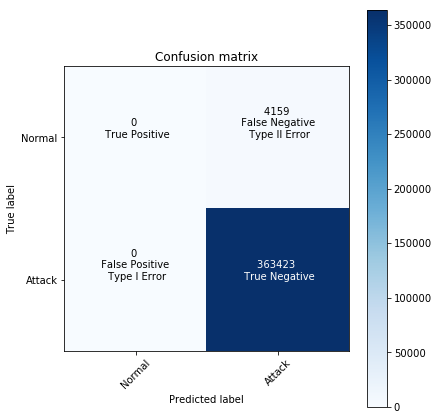

In [32]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [33]:
psg.mean().sort_values(by='f1_score', ascending=False)

train_score  test_score  f1_score  time_taken
no_of_features hidden_layers                                               
1              1                 0.994156    0.961742  0.979593   27.816367
               3                 0.993081    0.961742  0.979593   35.381034
4              3                 0.993081    0.961742  0.979593   35.247175
8              3                 0.994203    0.961742  0.979593   36.420131
16             3                 0.992988    0.961742  0.979593   37.000459
42             3                 0.993128    0.961738  0.979591   39.844855
4              1                 0.005937    0.038258  0.000000   27.103205
8              1                 0.005984    0.038258  0.000000   27.265537
16             1                 0.005657    0.038258  0.000000   29.930623
42             1                 0.007480    0.038258  0.000000   31.452015

In [34]:
psg.std()

train_score  test_score  f1_score  time_taken
no_of_features hidden_layers                                               
1              1                      0.0    0.055450  0.032586         0.0
               3                      0.0    0.055450  0.032586         0.0
4              1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.055450  0.032586         0.0
8              1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.055450  0.032586         0.0
16             1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.055450  0.032586         0.0
42             1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.055448  0.032585         0.0

In [35]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                (0.915726182876, 1.04345904093)
                3                (0.915726182876, 1.04345904093)
4               1                                     (nan, nan)
                3                (0.915726182876, 1.04345904093)
8               1                                     (nan, nan)
                3                (0.915726182876, 1.04345904093)
16              1                                     (nan, nan)
                3                (0.915726182876, 1.04345904093)
42              1                                     (nan, nan)
                3                 (0.915725991234, 1.0434555485)
dtype: object